<a href="https://colab.research.google.com/github/GUILLENJV/Series-de-Tiempo-/blob/master/Predicci%C3%B3n_del_precio_de_Bitcoin_con_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción del precio de Bitcoin con Python

*Elaborado por: Jesús Guillen*

En el siguiente trabajo se intenta predecir el precio de cierre diario de Bitcoin utilizando métodos de machine learning, donde se pretende generar un modelo de forecasting capaz de predecir el precio de Bitcoin. Se dispone de una serie temporal con los precios de apertura (Open), cierre (Close), máximo (High) y mínimo (Low) de Bitcoin en dólares estadounidenses (USD) desde el 2013-04-28 al 2022-06-28.

Una **serie temporal** (time series) es una sucesión de datos ordenados cronológicamente y espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado o empleando otras variables adicionales.

Para ello se hace uso de *Skforecast*, una sencilla librería de Python que permite, entre otras cosas, adaptar cualquier regresor de Scikit-learn a problemas de forecasting.


**Bitcoin (₿)** es una criptomoneda descentralizada que puede enviarse de un usuario a otro mediante la red bitcoin peer-to-peer sin necesidad de intermediarios. Las transacciones son verificadas y registradas en un libro de contabilidad público distribuido llamado blockchain. Los Bitcoins se crean como recompensa por un proceso conocido como minería y pueden intercambiarse por otras monedas, productos y servicios.


## Librerias

In [ ]:
!pip install cryptocmd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.1 MB/s 


In [ ]:
# Tratamiento de datos
import pandas as pd
import numpy as np
import datetime
from cryptocmd import CmcScraper

In [ ]:
# Gráficos
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Colores Bitcoin

palette_btc = {'naranja': '#f7931a',
               'blanco' : '#ffffff',
               'gris'   : '#4d4d4d',
               'azul'   : '#0d579b',
               'verde'  : '#329239'
              }

In [ ]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.7 MB/s 
     |████████████████████████████████| 9.8 MB 16.4 MB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Modelado y Forecasting

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

## Datos

La descarga de datos se realiza mediante cryptocmd. Esta librería es útil para descargar datos históricos de criptomonedas de la página Coinmarketcap. La información de cada columna es:

* Date: fecha del registro.

* Open: precio de apertura, precio al que cotiza un activo, en este caso el Bitcoin, en el comienzo del día. Expresado en dólares estadounidenses (USD).

* High: precio máximo del día, precio más alto alcanzado por el Bitcoin en ese día, (USD).

* Low: precio mínimo del día, precio más bajo alcanzado por el Bitcoin en ese día, (USD).

* Close: precio de cierre, precio al que cotiza el Bitcoin a la finalización del día, (USD).

* Volume: volumen, suma de las operaciones reales realizadas durante el día, (USD).

* Market Cap: capitalización de mercado, es el valor total de todas las acciones de una empresa o, en el caso de Bitcoin u otra criptomoneda, de todas las monedas que hay en circulación, (USD).

In [ ]:
# Descarga de datos

# Se inicializa el Scraper, se incluye simbolo, inicio y fin de la descarga
scraper = CmcScraper('BTC', '28-04-2013', '28-06-2022')

# Transformar datos recogidos en un dataframe
data = scraper.get_dataframe()
data.sort_values(by='Date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data)
pd.reset_option('display.max_columns')

,Date,Open,High,Low,Close,Volume,Market Cap
3348,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3347,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3346,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3345,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3344,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2022-06-24,21084.648062,21472.917913,20777.511580,21231.655771,2.495778e+10,4.050185e+11
3,2022-06-25,21233.609871,21520.914638,20964.585008,21502.338688,1.837254e+10,4.102023e+11
2,2022-06-26,21496.494740,21783.724766,21016.268806,21027.295309,1.802717e+10,4.011579e+11
1,2022-06-27,21028.238227,21478.089364,20620.198507,20735.477947,2.096570e+10,3.956069e+11


In [ ]:
# Preparación del dato
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'},
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

In [ ]:
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


## Halving del Bitcoin como variable exógena


El Halving es un evento programado y forma parte del diseño y funcionamiento de algunas criptomonedas. Los mineros se dedican a validar los bloques de transacciones de la red, en este caso Bitcoin, y, cada vez que lo logran, reciben como recompensa una cantidad de esa moneda digital. Esta cantidad es fija pero solo durante un tiempo.

En la blockchain de Bitcoin, cada vez que se añaden 210.000 bloques ocurre el cambio de recompensa. Este hecho, denominado como **halving**, se produce aproximadamente cada 4 años y reduce a la mitad las monedas que reciben los mineros.



In [ ]:
# Dict con la info de los halvings del Bitcoin

btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28',
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [ ]:
# Cálculo siguiente halving
# Se toma como base de partida los bloques restantes según la web
# coinmarketcap.com para el próximo halving a fecha de 2022-01-14
bloques_restantes = 97249
bloques_por_dia = 144

dias = bloques_restantes / bloques_por_dia

next_halving = pd.to_datetime('2022-06-28', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving

print(f'El próximo halving ocurrirá aproximadamente el: {next_halving}')

El próximo halving ocurrirá aproximadamente el: 2024-05-03


In [ ]:
# Incluir recompensas y cuenta regresiva para próximo halving en el dataset

data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):

    # Fecha inicial y final de cada halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')
    else:
        start_date = btc_halving['date'][i]

    end_date = btc_halving['date'][i+1]
    mask = (data.index >= start_date) & (data.index < end_date)

    # Rellenar columna 'reward' con las recompensas de minería
    data.loc[mask, 'reward'] = btc_halving['reward'][i]

    # Rellenar columna 'countdown_halving' con los días restantes
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)

    data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

In [ ]:
# Comprobar que se han creado los datos correctamente

print('Segundo halving:', btc_halving['date'][2])
display(data.loc['2016-07-08':'2016-07-09'])
print('')
print('Tercer halving:', btc_halving['date'][3])
display(data.loc['2020-05-10':'2020-05-11'])
print('')
print('Próximo halving:', btc_halving['date'][4])
data.tail(2)

Segundo halving: 2016-07-09


,open,close,high,low,reward,countdown_halving
date,,,,,,
2016-07-08,640.687988,666.523010,666.706970,636.466980,25.0,0.0
2016-07-09,666.383972,650.960022,666.383972,633.398987,12.5,1401.0



Tercer halving: 2020-05-11


,open,close,high,low,reward,countdown_halving
date,,,,,,
2020-05-10,9591.169231,8756.431142,9595.580629,8395.107451,12.50,0.0
2020-05-11,8755.535639,8601.796202,9033.471176,8374.322975,6.25,1452.0



Próximo halving: 2024-05-03


,open,close,high,low,reward,countdown_halving
date,,,,,,
2022-06-27,21028.238227,20735.477947,21478.089364,20620.198507,6.25,675.0
2022-06-28,20731.544346,20280.635650,21164.424097,20228.811579,6.25,674.0


##Gràficos de velas

In [ ]:
# Gráfico de velas japonesas interactivo con Plotly

candlestick = go.Candlestick(
                    x     = data.index,
                    open  = data.open,
                    close = data.close,
                    low   = data.low,
                    high  = data.high,
                    )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Chart Bitcoin/USD</b>', font=dict(size=30)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2],
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3],
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4],
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Segundo halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Tercer halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Cuarto halving')
                  ],
    xaxis_rangeslider_visible = False,
)

fig.show()

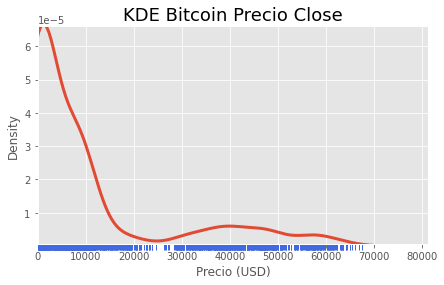

In [ ]:
# Distribución KDE del precio de cierre del Bitcoin

fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin Precio Close', fontsize=18)
p.set_xlabel('Precio (USD)');

En los datos de estudio se observa una distribución mayoritaria de precios por debajo de los 20.000 (USD). Esta etapa corresponde al periodo entre el año 2013 y septiembre de 2020. En cambio, desde 2021, el precio se ha situado en la zona de los 35.000 - 67.500 (USD), de igual manera se aprecia una caída bastante considerable para el periodo actual correspondiente al año 2022.

Tratar de modelar una serie temporal con una distribución muy asimétrica y distintos órdenes de magnitud a lo largo del tiempo puede ser complicado. Una estrategia, para tratar de minimizar estos problemas, es modelar los cambios (deltas) en lugar de los valores directos. Esto se podría simplificar aún más llevándolo al punto de indicar únicamente si el precio aumenta o disminuye respecto al día anterior.

*Nota: cuando una distribución es asimétrica, modelar los deltas en lugar del precio puede conseguir una distribución más simétrica.*


In [ ]:
# Se localizan los datos correspondientes para cada año

years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:

    year_open  = data.loc[data.index.year == year, 'open'][0]
    year_close = data.loc[data.index.year == year, 'close'][-1]
    year_low   = data.loc[data.index.year == year, 'low'].min()
    year_high  = data.loc[data.index.year == year, 'high'].max()

    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high])

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Se calcula el % de cambio entre el open y el close del año

df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(3)


,open,close,low,high,year_change
2013,135.300003,754.010010,65.526001,1156.140015,457.287504
2014,754.969971,320.192993,289.295990,1017.119995,-57.588645
2015,320.434998,430.566986,171.509995,495.562012,34.369526


In [ ]:
# Se crea una lista de dicts con las anotaciones de % de cambio para el gráfico

annotations_list = []
max_high = df_plot['high'].max()

for year in years:

    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y = df_aux['high'].values[0]/max_high + 0.05
    text = '{:.1f}%'.format(df_aux['year_change'].values[0])

    annotation = dict(x=loc_x, y=loc_y,
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center',
                      text=text)

    annotations_list.append(annotation)

# Gráfico de velas japonesas anual interactivo con Plotly

candlestick = go.Candlestick(
                    x     = pd.to_datetime(df_plot.index, format='%Y'),
                    open  = df_plot.open,
                    close = df_plot.close,
                    low   = df_plot.low,
                    high  = df_plot.high
                    )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Chart Bitcoin/USD por año</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
    )

fig.show()

In [ ]:
# Se localizan los datos correspondientes para cada mes

years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for mes in range(12):

        start_date = pd.to_datetime(f'{year}-{mes+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data.index >= start_date) & (data.index < end_date)

        if not data.loc[mask, :].empty:

            month_open  = data.loc[mask, 'open'][0]
            month_close = data.loc[mask, 'close'][-1]
            month_low   = data.loc[mask, 'low'].min()
            month_high  = data.loc[mask, 'high'].max()

            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(mes+1).zfill(2)}-{year}'])

            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

In [ ]:
# Gráfico boxplot para estacionalidad anual

# df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='close', by='mes', ax=ax)
# df_plot.groupby('mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por mes')
# fig.suptitle('');

df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 boxplot de los meses
fig1 = px.box(df_plot.sort_values('mes'), x='mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(df_plot.groupby('mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='mes', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

In [ ]:
# Gráfico boxplot para estacionalidad mensual

# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['dia_mes'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='close', by='dia_mes', ax=ax)
# data.groupby('dia_mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día del mes')
# fig.suptitle('');

data['dia_mes'] = pd.Series(data.index).dt.day.values

# fig 1 boxplot de los días del mes
fig1 = px.box(data.sort_values('dia_mes'), x='dia_mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de los días del mes
df_median = pd.DataFrame(data.groupby('dia_mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día del mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='día', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

In [ ]:
# Gráfico boxplot para estacionalidad semanal

# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['dia_semana'] = data.index.day_of_week + 1
# data.boxplot(column='close', by='dia_semana', ax=ax)
# data.groupby('dia_semana')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día de la semana');

data['dia_semana'] = data.index.day_of_week + 1

# fig 1 boxplot de los días de la semana
fig1 = px.box(data.sort_values('dia_semana'), x='dia_semana', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana los días de la semana
df_median = pd.DataFrame(data.groupby('dia_semana')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_semana', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día de la semana</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

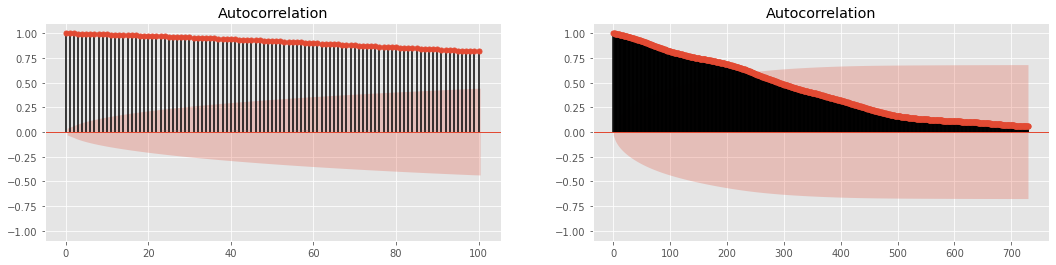

In [ ]:
# Gráfico autocorrelación

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

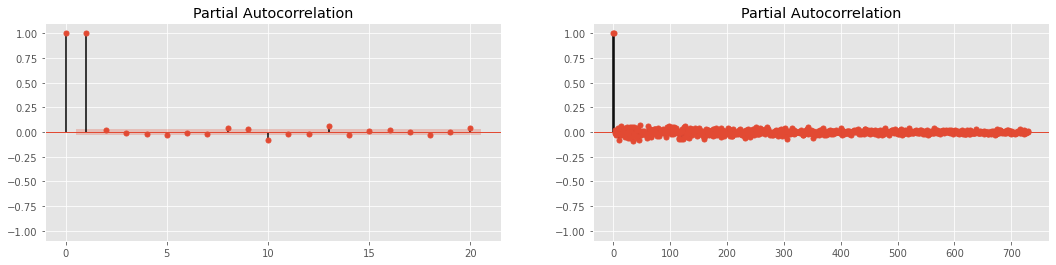

In [ ]:
# Gráfico autocorrelación parcial

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

# Baseline - Simulación Teoría del paseo aleatorio (Random Walk)

A la hora de generar un modelo predictivo es conveniente identificar un modelo base, o baseline, sobre el que ir comparando cada una de las iteraciones o modelos propuestos. En el caso de las finanzas, acorde a la teoría del paseo aleatorio o Random Walk, los precios de mercado se comportan de manera aleatoria y no dependiente de su serie temporal. De esta manera, la mejor estimación para el valor  tn+1  es el valor  tn  más un cambio impredecible.

Aunque se dispone de una serie temporal amplia, esta presenta periodos con precios muy diferenciados como se ha podido determinar en la exploración gráfica. Se opta por utilizar solo los dos últimos años de datos.

**La teoría del paseo aleatorio afirma que todo cambio, o evolución existente en los mercados financieros, no es medible y estimable. Ello se debe a la aleatoriedad y eficiencia de los mismos. Además señala que no es posible realizar predicciones fiables del precio de activos, estudiando únicamente su evolución pasada.**

In [ ]:
# Selección fechas train-test

inicio_train = '2020-06-01 00:00:00'
fin_train = '2021-12-31 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}  (n={len(data.loc[inicio_train:fin_train])})")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}  (n={len(data.loc[fin_train:])})")

Serie temporal completa : 2013-04-28 00:00:00 --- 2022-06-28 00:00:00  (n=3349)
Fechas train            : 2020-06-01 00:00:00 --- 2021-12-31 00:00:00  (n=579)
Fechas test             : 2022-01-01 00:00:00 --- 2022-06-28 00:00:00  (n=179)


Como se ha mencionado anteriormente, la teoría del paseo aleatorio sugiere que la mejor estimación para el valor  tn+1  es el valor  tn  más un cambio impredecible. De esta manera, el modelo más sencillo posible, y el cual se emplea como base, es aquel que simplemente utiliza el valor de  tn  como predicción para el valor  tn+1 .

In [ ]:
# Simulación Random Walk

df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Error de test

y_true = df_rw.loc[fin_train:, 'close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
metrica = mean_absolute_error(y_true, y_pred)

print(f'Error de test: {metrica}')
display(df_rw.loc[fin_train:,].tail(7))

Error de test: 946.2627503492469


,close,pred_close
date,,
2022-06-22,19987.029049,20710.597102
2022-06-23,21085.877161,19987.029049
2022-06-24,21231.655771,21085.877161
2022-06-25,21502.338688,21231.655771
2022-06-26,21027.295309,21502.338688
2022-06-27,20735.477947,21027.295309
2022-06-28,20280.635650,20735.477947


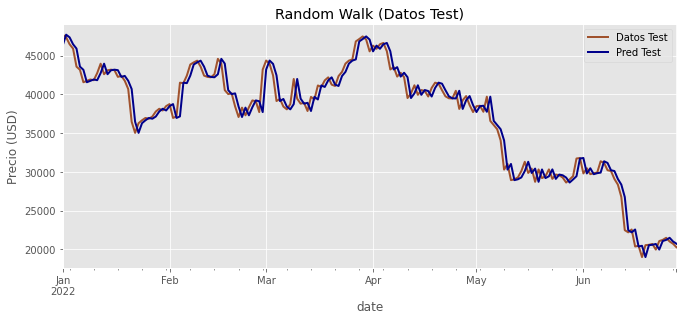

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test',
                                    c='sienna')
df_rw.loc[fin_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Pred Test',
                                    c='darkblue')
ax.set_title('Random Walk (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [ ]:
# DataFrame errores test modelos
# ==============================================================================
df_errores = pd.DataFrame({'modelo': 'Base - Random Walk', 'lags': 1,
                           'error_test': metrica, 'variables_exog': False},
                          index=[0])
df_errores

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,946.26275,False


El error del modelo en la partición de test es de 946.26275. En los siguientes apartados se pretende generar un modelo capaz de reducir este error.

## Forecaster Autorregresivo


Para intentar modelar el precio de Bitcoin se utilia un Forecaster Autorregresivo (ForecasterAutoreg) con un regresor LightGBM, una implementación del algoritmo de Gradient Boosting desarrollada por Microsoft que suele conseguir excelentes resultados.

Los estudios anteriores muestran una ausencia de autocorrelación más allá del primer lag. Una forma de verificarlo es entrenar varios modelos con una cantidad creciente de lags y comprobar si el error no se reduce. Esta aproximación se puede realizar mediante backtesting utilizando steps = 1 (predecir únicamente el siguiente valor de la serie,  tn+1 ) para reproducir la metodología del modelo Random Walk.

In [ ]:
# Backtest forecasters con diferentes lags

lags = [1, 7, 30]
metricas = []
predicciones_list = []

for lag in lags:

    # Crear forecaster
    forecaster = ForecasterAutoreg(
                    regressor = LGBMRegressor(random_state=123),
                    lags      = lag
                    )

    # Backtest test data 1 step
    metrica, predicciones = backtesting_forecaster(
                                 forecaster = forecaster,
                                 y          = data.loc[inicio_train:, 'close'],
                                 initial_train_size = len(data.loc[inicio_train:fin_train, 'close']),
                                 fixed_train_size   = True,
                                 steps      = 1,
                                 refit      = True,
                                 metric     = 'mean_absolute_error',
                                 verbose    = False
                                 )

    metricas.append(metrica)
    predicciones_list.append(predicciones)

Forecaster will be fit 179 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 179 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 179 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



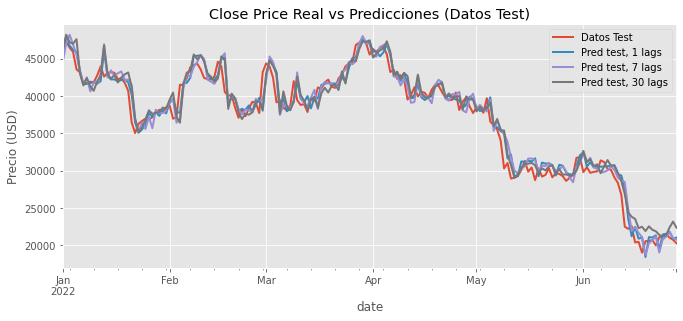

In [ ]:
# Gráfico

fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones test para diferentes lags
for predicciones, lag in zip(predicciones_list, lags):
    predicciones = predicciones.rename(columns={'pred': f'Pred test, {lag} lags'})
    predicciones.plot(ax=ax, linewidth=2)

ax.set_title('Close Price Real vs Predicciones (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [ ]:
# DataFrame errores de test modelos

modelo = 'LGBMRegressor'

df_errores = pd.concat([
                df_errores,
                pd.DataFrame({'modelo': modelo, 'lags': lags,
                              'error_test': metricas, 'variables_exog': False})
                ]).reset_index(drop=True)

df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,946.262750,False
1,LGBMRegressor,1,1085.594931,False
2,LGBMRegressor,7,1187.228921,False
3,LGBMRegressor,30,1201.330880,False


Los errores de test (los cuales reflejan cómo de bien generaliza cada modelo) demuestran que ninguno de los modelos mejora el baseline a pesar de que se incorpore más información del pasado (número de lags). En vista de los resultados, se intentan otras alternativas como es la incorporación de variables exógenas a la serie.

## Forecaster con variables exógenas

Además de utilizar predictores autorregresivos generados a partir del pasado de la propia variable respuesta, es posible añadir otras variables exógenas, cuyo valor a futuro se conoce, con el fin de mejorar la predicción. Algunos ejemplos típicos son:

* Festivos (local, nacional...)

* Mes del año

* Día de la semana

* Hora del día

Para este caso, se decide utilizar las variables resultantes del apartado sobre el halving del Bitcoin y, tras el estudio de la estacionalidad, el mes del año.

In [ ]:
# Cambio de las variables categóricas a tipo category

data['mes'] = data.index.month
data['mes'] = data['mes'].astype('category')
data['reward'] = data['reward'].astype('category')

# One hot encoding
data = pd.get_dummies(data, columns=['reward', 'mes'])
data.head(2)

,open,close,high,low,countdown_halving,dia_mes,dia_semana,reward_6.25,reward_12.5,reward_25.0,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006,1167.0,28,7,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2013-04-29,134.444000,144.539993,147.488007,134.000000,1166.0,29,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding

exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])
print(exog)

['reward_6.25', 'reward_12.5', 'reward_25.0', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12', 'countdown_halving']


In [ ]:
# Backtest forecaster con variables exógenas

forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = 1
                )

# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                             forecaster = forecaster,
                             y          = data.loc[inicio_train:, 'close'],
                             exog       = data.loc[inicio_train:, exog],
                             initial_train_size = len(data.loc[inicio_train:fin_train, 'close']),
                             fixed_train_size   = True,
                             steps      = 1,
                             interval   = [10, 90],
                             refit      = True,
                             metric     = 'mean_absolute_error',
                             verbose    = False
                             )
predicciones.tail(4)

Forecaster will be fit 179 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



,pred,lower_bound,upper_bound
2022-06-25,21495.950488,19961.943374,23100.471438
2022-06-26,21607.584108,20250.259489,22887.106958
2022-06-27,20973.260459,19264.414538,22334.552135
2022-06-28,20981.474057,19686.341034,22452.231895


In [ ]:
# Cobertura del intervalo en los datos de test

inside_interval = np.where(
                     (data.loc[predicciones.index, 'close'] >= predicciones['lower_bound']) & \
                     (data.loc[predicciones.index, 'close'] <= predicciones['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Cobertura del intervalo predicho con los datos de test: {100 * coverage}")

Cobertura del intervalo predicho con los datos de test: 74.30167597765363


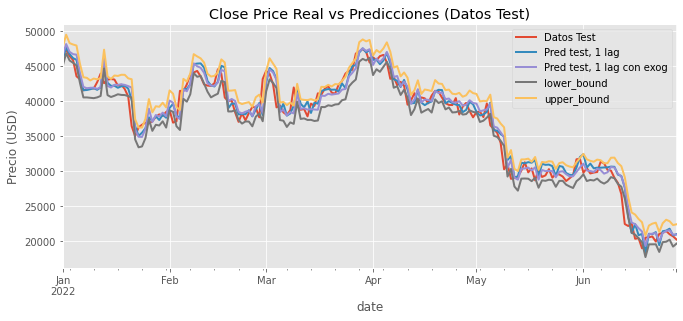

In [ ]:
# Gráfico

fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones 1 lag sin variables exógenas
predicciones_no_exog = predicciones_list[0].rename(columns={'pred': f'Pred test, 1 lag'})
predicciones_no_exog.plot(ax=ax, linewidth=2)

# Plot predicciones 1 lag con variables exógenas
predicciones_exog = predicciones.rename(columns={'pred': f'Pred test, 1 lag con exog'})
predicciones_exog.plot(ax=ax, linewidth=2)

ax.set_title('Close Price Real vs Predicciones (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [ ]:
# DataFrame errores de test modelos

modelo = 'LGBMRegressor'

df_errores = pd.concat([
                df_errores,
                pd.DataFrame({'modelo': modelo, 'lags': 1,
                              'error_test': metrica, 'variables_exog': True},
                             index=[4])
                ]).reset_index(drop=True)

df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,946.262750,False
4,LGBMRegressor,1,1073.684708,True
1,LGBMRegressor,1,1085.594931,False
2,LGBMRegressor,7,1187.228921,False
3,LGBMRegressor,30,1201.330880,False


En este caso, incorporar variables exógenas aumenta ligeramente la capacidad predictiva del modelo pero, aún así, no se supera la del modelo base.

# Conclusiones

Cuando se dispone de una serie temporal con ausencia de autocorrelación se deben buscar variables exógenas capaces de ayudar en el problema. Por ejemplo, si se intentase predecir el precio de Bitcoin a corto plazo (horas) podrían emplearse como variables exógenas el sentimiento del mercado mediante el análisis de tweets, impacto de los denominados key opinion leaders, análisis de noticias más relevantes, etc.